In [1]:
import pandas as pd
file_path = 'online_retail_II.xlsx'

In [2]:
df_2009 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
print(df_2009.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [15]:
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df_2009.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [7]:
df_2009.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

## Data Cleaning

In [ ]:
# Data Cleaning for 2009-2010 Data
df = df_2009.copy()

# Remove rows with missing Customer ID or Description
df = df.dropna(subset=['Customer ID', 'Description'])

# Remove rows with non-positive Quantity or Price
df = df[(df['Quantity'] > 0 ) & (df['Price'] > 0)]
df['Invoice'] = df['Invoice'].astype(str)

# Remove canceled orders (Invoice starting with 'C')
df = df[~df['Invoice'].str.startswith('C')]

# Create Total Sales column
df['TotalSales'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove duplicate rows
df = df.drop_duplicates()

# Convert Customer ID to integer
df['Customer ID'] = df['Customer ID'].astype(int)

## Activity-Based Retention

In [4]:
df = df.groupby(['Invoice', 'Customer ID', 'InvoiceDate', 'Country'], as_index=False).agg({'TotalSales': 'sum'})
df = df.sort_values(['Customer ID', 'InvoiceDate'])

df['PrevInvoiceDate'] = df.groupby('Customer ID')['InvoiceDate'].shift(1)
df['DaysBetween'] = (df['InvoiceDate'] - df['PrevInvoiceDate']).dt.days
df.head()

,Invoice,Customer ID,InvoiceDate,Country,TotalSales,PrevInvoiceDate,DaysBetween
1006,491725,12346,2009-12-14 08:34:00,United Kingdom,45.0,NaT,NaN
1017,491742,12346,2009-12-14 11:00:00,United Kingdom,22.5,2009-12-14 08:34:00,0.0
1019,491744,12346,2009-12-14 11:02:00,United Kingdom,22.5,2009-12-14 11:00:00,0.0
1361,492718,12346,2009-12-18 10:47:00,United Kingdom,22.5,2009-12-14 11:02:00,3.0
1363,492722,12346,2009-12-18 10:55:00,United Kingdom,1.0,2009-12-18 10:47:00,0.0


## Days between Purchases Histogram

Text(0.5, 1.0, 'Histogram of Days Between Purchases')

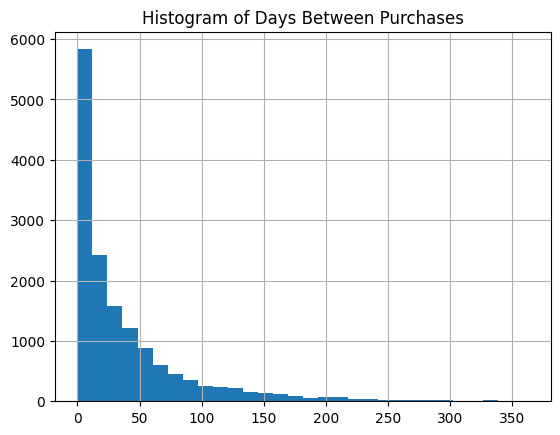

In [5]:
histogram = df['DaysBetween'].hist(bins=30)
histogram.set_title('Histogram of Days Between Purchases')

In [9]:
reference_date = df['InvoiceDate'].max()

last_purchase = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
last_purchase['DaysSinceLastPurchase'] = (reference_date - last_purchase['InvoiceDate']).dt.days
last_purchase['Churned'] = last_purchase['DaysSinceLastPurchase'] > 180

## Churned vs Active Customers Analysis

In [15]:
customer_metrics = df.groupby('Customer ID').agg(
    total_revenue=('TotalSales', 'sum'),
    num_orders=('Invoice', 'nunique'),
    avg_order_value=('TotalSales', 'mean'),
    first_purchse=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
)
customer_metrics['tenure_days'] = (customer_metrics['last_purchase'] - customer_metrics['first_purchse']).dt.days
customer_metrics

,total_revenue,num_orders,avg_order_value,first_purchse,last_purchase,tenure_days
Customer ID,,,,,,
12346,372.86,11,33.896364,2009-12-14 08:34:00,2010-06-28 13:53:00,196
12347,1323.32,2,661.660000,2010-10-31 14:20:00,2010-12-07 14:57:00,37
12348,222.16,1,222.160000,2010-09-27 14:59:00,2010-09-27 14:59:00,0
12349,2671.14,3,890.380000,2010-04-29 13:20:00,2010-10-28 08:23:00,181
12351,300.93,1,300.930000,2010-11-29 15:23:00,2010-11-29 15:23:00,0
...,...,...,...,...,...,...
18283,619.37,6,103.228333,2010-02-19 17:16:00,2010-11-22 15:30:00,275
18284,461.68,1,461.680000,2010-10-04 11:33:00,2010-10-04 11:33:00,0
18285,427.00,1,427.000000,2010-02-17 10:24:00,2010-02-17 10:24:00,0
